In [ ]:
import torch
from torch import nn
import time
import torchtext
import numpy as np

import random

from collections import defaultdict, Counter

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

In [ ]:
def read_data(corpus_file, datafields):
    with open(corpus_file, encoding='utf-8') as f:
        examples = []
        words = []
        labels = []
        for line in f:
            line = line.strip()
            if not line:
                examples.append(torchtext.data.Example.fromlist([words, labels], datafields))
                words = []
                labels = []
            else:
                columns = line.split()
                words.append(columns[0])
                labels.append(columns[-1])
        return torchtext.data.Dataset(examples, datafields)

In [ ]:
class RNNTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        # Embedding layer. If we're using pre-trained embeddings, copy them
        # into our embedding module.
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        # RNN layer. We're using a bidirectional GRU with one layer.
        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        # Output layer. As in the example last week, the input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        # To deal with the padding positions later, we need to know the
        # encoding of the padding dummy word and the corresponding dummy output tag.
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        # Loss function that we will use during training.
        self.loss = torch.nn.CrossEntropyLoss(reduction='sum')
        
    def compute_outputs(self, sentences):
        # The words in the documents are encoded as integers. The shape of the documents
        # tensor is (max_len, n_docs), where n_docs is the number of documents in this batch,
        # and max_len is the maximal length of a document in the batch.

        # First look up the embeddings for all the words in the documents.
        # The shape is now (max_len, n_sentences, emb_dim).        
        embedded = self.embedding(sentences)

        # Apply the RNN.
        # The shape of the RNN output tensor is (max_len, n_sentences, 2*rnn_size).
        rnn_out, _ = self.rnn(embedded)
        
        # Apply the linear output layer.
        # The shape of the output tensor is (max_len, n_sentences, n_labels).
        out = self.top_layer(rnn_out)
        
        # Find the positions where the token is a dummy padding token.
        pad_mask = (sentences == self.pad_word_id).float()

        # For these positions, we add some large number in the column corresponding
        # to the dummy padding label.
        out[:, :, self.pad_label_id] += pad_mask*10000

        return out
                
    def forward(self, sentences, labels):
        # As discussed above, this method first computes the predictions, and then
        # the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores = self.compute_outputs(sentences)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)
        return self.loss(scores, labels)

    def predict(self, sentences):
        # Compute the outputs from the linear units.
        scores = self.compute_outputs(sentences)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted = scores.argmax(dim=2)

        # We transpose the prediction to (n_sentences, max_len), and convert it
        # to a NumPy matrix.
        return predicted.t().cpu().numpy()

In [ ]:
pip install pytorch-crf

In [ ]:
from torchcrf import CRF

class RNNCRFTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        self.crf = CRF(self.n_labels)
        
    def compute_outputs(self, sentences):
        embedded = self.embedding(sentences)
        rnn_out, _ = self.rnn(embedded)
        out = self.top_layer(rnn_out)
        
        pad_mask = (sentences == self.pad_word_id).float()
        out[:, :, self.pad_label_id] += pad_mask*10000
        
        return out
                
    def forward(self, sentences, labels):
        # Compute the outputs of the lower layers, which will be used as emission
        # scores for the CRF.
        scores = self.compute_outputs(sentences)

        # We return the loss value. The CRF returns the log likelihood, but we return 
        # the *negative* log likelihood as the loss value.            
        # PyTorch's optimizers *minimize* the loss, while we want to *maximize* the
        # log likelihood.
        return -self.crf(scores, labels)
            
    def predict(self, sentences):
        # Compute the emission scores, as above.
        scores = self.compute_outputs(sentences)

        # Apply the Viterbi algorithm to get the predictions. This implementation returns
        # the result as a list of lists (not a tensor), corresponding to a matrix
        # of shape (n_sentences, max_len).
        return self.crf.decode(scores)

In [ ]:
# Convert a list of BIO labels, coded as integers, into spans identified by a beginning, an end, and a label.
# To allow easy comparison later, we store them in a dictionary indexed by the start position.
def to_spans(l_ids, voc):
    spans = {}
    current_lbl = None
    current_start = None
    for i, l_id in enumerate(l_ids):
        l = voc[l_id]

        if l[0] == 'B': 
            # Beginning of a named entity: B-something.
            if current_lbl:
                # If we're working on an entity, close it.
                spans[current_start] = (current_lbl, i)
            # Create a new entity that starts here.
            current_lbl = l[2:]
            current_start = i
        elif l[0] == 'I':
            # Continuation of an entity: I-something.
            if current_lbl:
                # If we have an open entity, but its label does not
                # correspond to the predicted I-tag, then we close
                # the open entity and create a new one.
                if current_lbl != l[2:]:
                    spans[current_start] = (current_lbl, i)
                    current_lbl = l[2:]
                    current_start = i
            else:
                # If we don't have an open entity but predict an I tag,
                # we create a new entity starting here even though we're
                # not following the format strictly.
                current_lbl = l[2:]
                current_start = i
        else:
            # Outside: O.
            if current_lbl:
                # If we have an open entity, we close it.
                spans[current_start] = (current_lbl, i)
                current_lbl = None
                current_start = None
    return spans

# Compares two sets of spans and records the results for future aggregation.
def compare(gold, pred, stats):
    for start, (lbl, end) in gold.items():
        stats['total']['gold'] += 1
        stats[lbl]['gold'] += 1
    for start, (lbl, end) in pred.items():
        stats['total']['pred'] += 1
        stats[lbl]['pred'] += 1
    for start, (glbl, gend) in gold.items():
        if start in pred:
            plbl, pend = pred[start]
            if glbl == plbl and gend == pend:
                stats['total']['corr'] += 1
                stats[glbl]['corr'] += 1

# This function combines the auxiliary functions we defined above.
def evaluate_iob(predicted, gold, label_field, stats):
    # The gold-standard labels are assumed to be an integer tensor of shape
    # (max_len, n_sentences), as returned by torchtext.
    gold_cpu = gold.t().cpu().numpy()
    gold_cpu = list(gold_cpu.reshape(-1))

    # The predicted labels assume the format produced by pytorch-crf, so we
    # assume that they have been converted into a list already.
    # We just flatten the list.
    pred_cpu = [l for sen in predicted for l in sen]
    
    # Compute spans for the gold standard and prediction.
    gold_spans = to_spans(gold_cpu, label_field.vocab.itos)
    pred_spans = to_spans(pred_cpu, label_field.vocab.itos)

    # Finally, update the counts for correct, predicted and gold-standard spans.
    compare(gold_spans, pred_spans, stats)

# Computes precision, recall and F-score, given a dictionary that contains
# the counts of correct, predicted and gold-standard items.
def prf(stats):
    if stats['pred'] == 0:
        return 0, 0, 0
    p = stats['corr']/stats['pred']
    r = stats['corr']/stats['gold']
    if p > 0 and r > 0:
        f = 2*p*r/(p+r)
    else:
        f = 0
    return p, r, f

.vector_cache/glove.840B.300d.zip: 0.00B [00:00, ?B/s]

We are using pre-trained word embeddings.


.vector_cache/glove.840B.300d.zip: 2.18GB [16:58, 2.14MB/s]                            
100%|█████████▉| 2195392/2196017 [05:00<00:00, 7809.12it/s]

Epoch 1: train loss = 0.4689, val f1: 0.6290, time = 3.8796
Epoch 2: train loss = 0.1944, val f1: 0.7136, time = 3.3289
Epoch 3: train loss = 0.1260, val f1: 0.7644, time = 3.3798
Epoch 4: train loss = 0.0930, val f1: 0.7712, time = 3.3130
Epoch 5: train loss = 0.0824, val f1: 0.7880, time = 3.4266
Epoch 6: train loss = 0.0763, val f1: 0.7207, time = 3.2743
Epoch 7: train loss = 0.0712, val f1: 0.7850, time = 3.2389
Epoch 8: train loss = 0.0634, val f1: 0.8154, time = 3.3193
Epoch 9: train loss = 0.0568, val f1: 0.7965, time = 3.4712
Epoch 10: train loss = 0.0475, val f1: 0.8201, time = 3.4187
Epoch 11: train loss = 0.0435, val f1: 0.8368, time = 3.5256
Epoch 12: train loss = 0.0329, val f1: 0.8426, time = 3.2245
Epoch 13: train loss = 0.0311, val f1: 0.8446, time = 3.3187
Epoch 14: train loss = 0.0258, val f1: 0.8441, time = 3.5745
Epoch 15: train loss = 0.0229, val f1: 0.8455, time = 3.2486
Epoch 16: train loss = 0.0219, val f1: 0.8452, time = 3.3429
Epoch 17: train loss = 0.0193, va

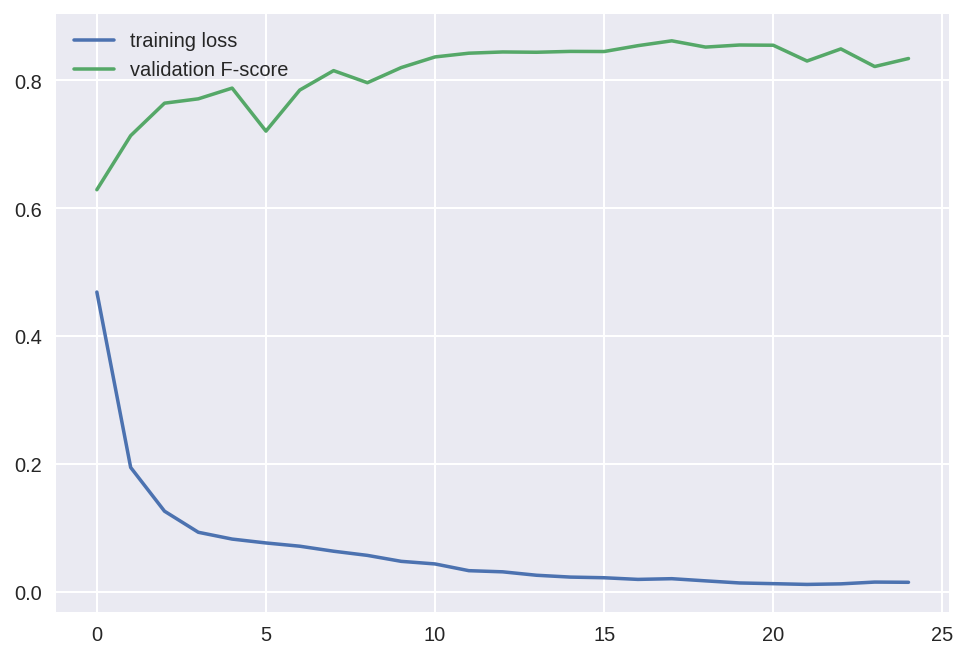

In [ ]:
class Tagger:
    
    def __init__(self, lower):
        self.TEXT = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, lower=lower)
        self.LABEL = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, unk_token=None)
        self.fields = [('text', self.TEXT), ('label', self.LABEL)]
        self.device = 'cuda'
        
    def tag(self, sentences):
        # This method applies the trained model to a list of sentences.
        
        # First, create a torchtext Dataset containing the sentences to tag.
        examples = []
        for sen in sentences:
            labels = ['?']*len(sen) # placeholder
            examples.append(torchtext.data.Example.fromlist([sen, labels], self.fields))
        dataset = torchtext.data.Dataset(examples, self.fields)
        
        iterator = torchtext.data.Iterator(
            dataset,
            device=self.device,
            batch_size=64,
            repeat=False,
            train=False,
            sort=False)
        
        # Apply the trained model to all batches.
        out = []
        self.model.eval()
        with torch.no_grad():
            for batch in iterator:
                # Call the model's predict method. This returns a list of NumPy matrix
                # containing the integer-encoded tags for each sentence.
                predicted = self.model.predict(batch.text)

                # Convert the integer-encoded tags to tag strings.
                for tokens, pred_sen in zip(sentences, predicted):
                    out.append([self.LABEL.vocab.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
        return out
                
    def train(self):
        # Read training and validation data according to the predefined split.
        train_examples = read_data('data/eng.train.iob', self.fields)
        valid_examples = read_data('data/eng.valid.iob', self.fields)

        # Count the number of words and sentences.
        n_tokens_train = 0
        n_sentences_train = 0
        for ex in train_examples:
            n_tokens_train += len(ex.text) + 2
            n_sentences_train += 1
        n_tokens_valid = 0       
        for ex in valid_examples:
            n_tokens_valid += len(ex.text)

        # Load the pre-trained embeddings that come with the torchtext library.
        use_pretrained = True
        if use_pretrained:
            print('We are using pre-trained word embeddings.')
            self.TEXT.build_vocab(train_examples, vectors="glove.840B.300d")
        else:  
            print('We are training word embeddings from scratch.')
            self.TEXT.build_vocab(train_examples, max_size=5000)
        self.LABEL.build_vocab(train_examples)
    
        # Create one of the models defined above.
        #self.model = RNNTagger(self.TEXT, self.LABEL, emb_dim=300, rnn_size=128, update_pretrained=False)
        self.model = RNNCRFTagger(self.TEXT, self.LABEL, emb_dim=300, rnn_size=128, update_pretrained=False)
    
        self.model.to(self.device)
    
        batch_size = 1024
        n_batches = np.ceil(n_sentences_train / batch_size)

        mean_n_tokens = n_tokens_train / n_batches

        train_iterator = torchtext.data.BucketIterator(
            train_examples,
            device=self.device,
            batch_size=batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            train=True,
            sort=True)

        valid_iterator = torchtext.data.BucketIterator(
            valid_examples,
            device=self.device,
            batch_size=64,
            sort_key=lambda x: len(x.text),
            repeat=False,
            train=False,
            sort=True)
    
        train_batches = list(train_iterator)
        valid_batches = list(valid_iterator)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01, weight_decay=1e-5)

        n_labels = len(self.LABEL.vocab)

        history = defaultdict(list)    
        
        n_epochs = 25
        
        for i in range(1, n_epochs + 1):

            t0 = time.time()

            loss_sum = 0

            self.model.train()
            for batch in train_batches:
                
                # Compute the output and loss.
                loss = self.model(batch.text, batch.label) / mean_n_tokens
                
                optimizer.zero_grad()            
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

            train_loss = loss_sum / n_batches
            history['train_loss'].append(train_loss)

            # Evaluate on the validation set.
            if i % 1 == 0:
                stats = defaultdict(Counter)

                self.model.eval()
                with torch.no_grad():
                    for batch in valid_batches:
                        # Predict the model's output on a batch.
                        predicted = self.model.predict(batch.text)                   
                        # Update the evaluation statistics.
                        evaluate_iob(predicted, batch.label, self.LABEL, stats)
            
                # Compute the overall F-score for the validation set.
                _, _, val_f1 = prf(stats['total'])
                
                history['val_f1'].append(val_f1)
            
                t1 = time.time()
                print(f'Epoch {i}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')
           
        # After the final evaluation, we print more detailed evaluation statistics, including
        # precision, recall, and F-scores for the different types of named entities.
        print()
        print('Final evaluation on the validation set:')
        p, r, f1 = prf(stats['total'])
        print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        for label in stats:
            if label != 'total':
                p, r, f1 = prf(stats[label])
                print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        
        plt.plot(history['train_loss'])
        plt.plot(history['val_f1'])
        plt.legend(['training loss', 'validation F-score'])

tagger = Tagger(lower=False)
tagger.train()

In [ ]:
def print_tags(sentence):
    tokens = sentence.split()
    tags = tagger.tag([tokens])[0]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [ ]:
print_tags('John Johnson was born in Moscow , lives in Gothenburg , and works for Chalmers Technical University and the University of Gothenburg .')

John        I-PER
Johnson     I-PER
was         O
born        O
in          O
Moscow      I-LOC
,           O
lives       O
in          O
Gothenburg  I-LOC
,           O
and         O
works       O
for         O
Chalmers    I-ORG
Technical   I-ORG
University  I-ORG
and         O
the         O
University  I-ORG
of          O
Gothenburg  I-LOC
.           O


In [ ]:
print_tags('John XYZXYZABC was born in XYZABC .')

John        I-PER
XYZXYZABC   I-PER
was         O
born        O
in          O
XYZABC      I-LOC
.           O


In [ ]:
print_tags('Paris Hilton lives in New York .')

Paris       I-LOC
Hilton      O
lives       O
in          O
New         I-LOC
York        I-LOC
.           O


In [ ]:
print_tags('New York Stock Exchange is in New York .')

New         I-ORG
York        I-ORG
Stock       I-ORG
Exchange    I-ORG
is          O
in          O
New         I-LOC
York        I-LOC
.           O


Reference: http://www.cse.chalmers.se/~richajo/nlp2019/l6/Sequence%20tagging%20example.html
